In [1]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import os
import matplotlib as mpl
seaborn.set_context('talk')

In [2]:
with open('active_learning_data/dataset_names.txt') as f:
    names = f.readlines()
    names = [n[:-1] for n in names]
names = ['antibacterial', 'anticancer', 'antifungal', 'anti-HIV', 'anti-MRSA', 'antiparasital', 'antiviral', 'hemolytic', 'soluble', 'SHP-2', 'TULA-2', 'human']
print(names)
print(len(names))
MAX_TRAJS = 30
XLIM = 25

['antibacterial', 'anticancer', 'antifungal', 'anti-HIV', 'anti-MRSA', 'antiparasital', 'antiviral', 'hemolytic', 'soluble', 'SHP-2', 'TULA-2', 'human']
12


(0.8198616863905327, 0.016223349028543558)

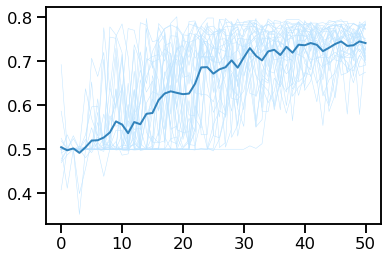

In [3]:
def plot_condition(ax, label, color, linestyle, location, trace=True, horizontal=False):
    # mimic how an alpha would blend,
    # but don't use alpha so that we don't create
    # false "mean lines"
    base_color = mpl.colors.to_rgb(color)
    base_hsv = mpl.colors.rgb_to_hsv(base_color)
    base_hsv[1] *= 0.3
    base_hsv[2] = 1.0
    trace_color = mpl.colors.hsv_to_rgb(base_hsv)
    aucs, accs = [], []
    # load lines
    for i in range(MAX_TRAJS):
        fn = '{}/{}_withheld_accuracy.txt'.format(location, str(i).zfill(4))
        auc = '{}/{}_auc.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(fn):
            break
        d = np.genfromtxt(fn)
        auc = np.genfromtxt(auc)
        aucs.append(auc)
        accs.append(d)
        if trace:
            ax.plot(d, alpha=1.0, lw=0.5, color=trace_color, linestyle=linestyle)        
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + fn)
    accs = np.array(accs)
    avg = np.mean(accs, axis=0)
    if horizontal:
        ax.axhline(avg[-1], lw=1.0 if trace else 1.5, label=label, color=color, linestyle=linestyle)
    else:
        ax.plot(avg, alpha=0.9, lw=2.0 if trace else 1.5, label=label, color=color, linestyle=linestyle)
    return (np.mean(aucs), np.std(aucs))
plt.figure()
ax = plt.gca()
#plot_condition(ax, 'foo', 'C0', '-', 'reptile-weights/random/0/', trace=False)
plot_condition(ax, 'foo', 'C0', '-', 'models/random/0/', trace=True)

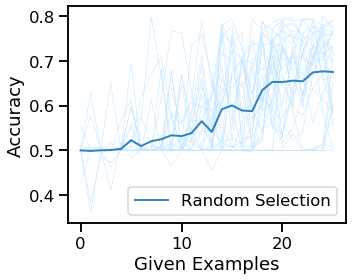

In [15]:
plt.figure(figsize=(5,4))
ax = plt.gca()
plot_condition(ax, 'Random Selection', 'C0', '-', 'models-25/random/0/', trace=True)
plt.legend()
plt.xlabel('Given Examples')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('example.png')

In [4]:
def get_auc(location, accuracy=False):
    aucs = []
    for i in range(MAX_TRAJS):
        if accuracy:
            auc = '{}/{}_withheld_accuracy.txt'.format(location, str(i).zfill(4))
        else:
            auc = '{}/{}_auc.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(auc):
            break
        auc = np.genfromtxt(auc)[-1] if accuracy else np.genfromtxt(auc)
        aucs.append(auc)
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + auc)
    return (np.mean(aucs), np.std(aucs))
get_auc('reptile-models/random/1', False)

(0.8503150598613736, 0.021045527087976502)

In [5]:
def make_auc_tex_table(locations, all_loc='models'):
    strategy_names = ['random', 'qbc', 'umin']
    if type(locations) != list:
        locations = [locations]
    for location in locations:
        for s in strategy_names:
            print('{}-{}'.format(location,s), end=' ')
    print('')
    for i,n in enumerate(names):
        print(n, end=' & ')
        auc = get_auc(os.path.join(all_loc, 'all', str(i)))
        print('$ {:.2f}$'.format(*auc), end=' & ')
        for location in locations:
            for s in strategy_names:
                auc = get_auc(os.path.join(location, s, str(i)))
                print('$ {:.2f} \pm {:.2f}$'.format(*auc), end=' & ' if s != strategy_names[-1] or location != locations[-1] else '')
        print('\\\\')

In [6]:
def make_auc_html_table(location, all_loc='models'):
    strategy_names = ['random', 'qbc', 'umin']
    for i,n in enumerate(names):
        print('<tr> <td> {} </td>'.format(n), end=' ')
        auc = get_auc(os.path.join(all_loc, 'all', str(i)))
        print('<td> {:.2f} </td>'.format(auc[0]), end=' ')
        for s in strategy_names:
            auc = get_auc(os.path.join(location, s, str(i)))
            print('<td> {:.2f} ± {:.2f} </td>'.format(*auc), end=' ' if s != strategy_names[-1] else '')
        print('</tr>')
make_auc_html_table('reptile-models-25')

<tr> <td> antibacterial </td> <td> 0.84 </td> <td> 0.81 ± 0.01 </td> <td> 0.82 ± 0.01 </td> <td> 0.83 ± 0.01 </td></tr>
<tr> <td> anticancer </td> <td> 0.86 </td> <td> 0.88 ± 0.04 </td> <td> 0.92 ± 0.02 </td> <td> 0.86 ± 0.03 </td></tr>
<tr> <td> antifungal </td> <td> 0.84 </td> <td> 0.84 ± 0.01 </td> <td> 0.80 ± 0.02 </td> <td> 0.83 ± 0.01 </td></tr>
<tr> <td> anti-HIV </td> <td> 0.89 </td> <td> 0.76 ± 0.05 </td> <td> 0.79 ± 0.04 </td> <td> 0.84 ± 0.03 </td></tr>
<tr> <td> anti-MRSA </td> <td> 0.97 </td> <td> 0.98 ± 0.01 </td> <td> 0.96 ± 0.02 </td> <td> 1.00 ± 0.01 </td></tr>
<tr> <td> antiparasital </td> <td> 0.96 </td> <td> 0.90 ± 0.03 </td> <td> 0.95 ± 0.02 </td> <td> 0.91 ± 0.03 </td></tr>
<tr> <td> antiviral </td> <td> 0.76 </td> <td> 0.89 ± 0.02 </td> <td> 0.81 ± 0.03 </td> <td> 0.84 ± 0.04 </td></tr>
<tr> <td> hemolytic </td> <td> 0.98 </td> <td> 0.89 ± 0.05 </td> <td> 0.85 ± 0.10 </td> <td> 0.89 ± 0.03 </td></tr>
<tr> <td> soluble </td> <td> 0.59 </td> <td> 0.51 ± 0.02 </td> 

In [7]:
make_auc_tex_table(['models-25', 'reptile-models-25'])

models-25-random models-25-qbc models-25-umin reptile-models-25-random reptile-models-25-qbc reptile-models-25-umin 
antibacterial & $ 0.84$ & $ 0.81 \pm 0.02$ & $ 0.82 \pm 0.04$ & $ 0.79 \pm 0.07$ & $ 0.81 \pm 0.01$ & $ 0.82 \pm 0.01$ & $ 0.83 \pm 0.01$\\
anticancer & $ 0.86$ & $ 0.83 \pm 0.04$ & $ 0.83 \pm 0.03$ & $ 0.76 \pm 0.04$ & $ 0.88 \pm 0.04$ & $ 0.92 \pm 0.02$ & $ 0.86 \pm 0.03$\\
antifungal & $ 0.84$ & $ 0.81 \pm 0.04$ & $ 0.83 \pm 0.06$ & $ 0.81 \pm 0.07$ & $ 0.84 \pm 0.01$ & $ 0.80 \pm 0.02$ & $ 0.83 \pm 0.01$\\
anti-HIV & $ 0.89$ & $ 0.85 \pm 0.03$ & $ 0.89 \pm 0.05$ & $ 0.76 \pm 0.07$ & $ 0.76 \pm 0.05$ & $ 0.79 \pm 0.04$ & $ 0.84 \pm 0.03$\\
anti-MRSA & $ 0.97$ & $ 0.90 \pm 0.02$ & $ 0.96 \pm 0.03$ & $ 0.97 \pm 0.02$ & $ 0.98 \pm 0.01$ & $ 0.96 \pm 0.02$ & $ 1.00 \pm 0.01$\\
antiparasital & $ 0.96$ & $ 0.88 \pm 0.04$ & $ 0.95 \pm 0.03$ & $ 0.93 \pm 0.03$ & $ 0.90 \pm 0.03$ & $ 0.95 \pm 0.02$ & $ 0.91 \pm 0.03$\\
antiviral & $ 0.76$ & $ 0.78 \pm 0.08$ & $ 0.86 \pm 0.03$ 

In [8]:
make_auc_tex_table('models-25')
make_auc_html_table('models-25')

models-25-random models-25-qbc models-25-umin 
antibacterial & $ 0.84$ & $ 0.81 \pm 0.02$ & $ 0.82 \pm 0.04$ & $ 0.79 \pm 0.07$\\
anticancer & $ 0.86$ & $ 0.83 \pm 0.04$ & $ 0.83 \pm 0.03$ & $ 0.76 \pm 0.04$\\
antifungal & $ 0.84$ & $ 0.81 \pm 0.04$ & $ 0.83 \pm 0.06$ & $ 0.81 \pm 0.07$\\
anti-HIV & $ 0.89$ & $ 0.85 \pm 0.03$ & $ 0.89 \pm 0.05$ & $ 0.76 \pm 0.07$\\
anti-MRSA & $ 0.97$ & $ 0.90 \pm 0.02$ & $ 0.96 \pm 0.03$ & $ 0.97 \pm 0.02$\\
antiparasital & $ 0.96$ & $ 0.88 \pm 0.04$ & $ 0.95 \pm 0.03$ & $ 0.93 \pm 0.03$\\
antiviral & $ 0.76$ & $ 0.78 \pm 0.08$ & $ 0.86 \pm 0.03$ & $ 0.84 \pm 0.07$\\
hemolytic & $ 0.98$ & $ 0.82 \pm 0.05$ & $ 0.82 \pm 0.04$ & $ 0.81 \pm 0.04$\\
soluble & $ 0.59$ & $ 0.50 \pm 0.01$ & $ 0.50 \pm 0.02$ & $ 0.50 \pm 0.02$\\
SHP-2 & $ 0.75$ & $ 0.61 \pm 0.07$ & $ 0.55 \pm 0.10$ & $ 0.52 \pm 0.07$\\
TULA-2 & $ 0.65$ & $ 0.51 \pm 0.12$ & $ 0.51 \pm 0.10$ & $ 0.48 \pm 0.09$\\
human & $ 0.87$ & $ 0.86 \pm 0.01$ & $ 0.86 \pm 0.01$ & $ 0.85 \pm 0.01$\\
<tr> <td>

In [28]:
def plot_dataset(ax, ml_location, location, strategy, index, xlabel=False, ylabel=False, legend=False, ml=True, zoom=False, title=None, baseline_loc=None):
    if title is None:
        ax.set_title(names[index])
    else:
        ax.set_title(title)
    if baseline_loc is None:
        baseline_loc = location
    index = str(index)
    strategy_names = {'umin': 'Uncertainty', 'qbc': 'QBC'}
    aucs = []
    aucs.append(plot_condition(ax, 'Baseline', 'gray', '-', os.path.join(location, 'all', index), trace=False, horizontal=True))
    if strategy is not None:
        aucs.append(plot_condition(ax, strategy_names[strategy], 'C0', '-', os.path.join(location, strategy, index), trace=not ml))
        aucs.append(plot_condition(ax, 'Random', 'C2', '--', os.path.join(location, 'random', index), trace=False))
    else:
        aucs.append(plot_condition(ax, 'Random', 'C0', '-', os.path.join(location, 'random', index), trace=True))
        
    if ml:
        aucs.append(plot_condition(ax, 'ML+' + strategy_names[strategy], 'C1', '-', os.path.join(ml_location, strategy, index), trace=True))
        aucs.append(plot_condition(ax, 'ML+Random', 'C3', '--', os.path.join(ml_location, 'random', index), trace=False))
    if zoom:
        ax.set_xlim(0,5)
        #ax.set_ylim(0.45,0.75)
    else:
        ax.set_xlim(0,XLIM)
        #ax.set_ylim(0.45,1.0)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.set_xticks([0,XLIM // 2, XLIM])
    
    if legend:
        ax.legend()
    if xlabel:
        ax.set_xlabel('Given Examples')
    if ylabel:
        ax.set_ylabel('Accuracy')
    return aucs

In [29]:
def plot_strategy(ml_location, location, strategy, ml=True, zoom=False, stop=len(names)):
    fig, axs= plt.subplots(nrows=3, ncols=4, figsize=(14,8), sharex=True, sharey=False)
    print('Data Standard'.format(strategy), end='')
    if ml:
        print(' ML+{} ML+Random'.format(strategy))
    else:
        print(' {} Random'.format(strategy))
    for i in range(3):
        for j in range(4):
            k = i * 4 + j
            line = [names[k]] + plot_dataset(axs[i,j], ml_location, location, strategy, k, 
                                             xlabel = i == 2, ylabel=j == 0,
                                             legend = k == len(names), ml=ml, zoom=zoom)
            if k == 7:
                axs[i,j].legend(loc='upper right', bbox_to_anchor=(2.0, 1.0), fancybox=True, shadow=True, fontsize=10)
    plt.tight_layout()
    plt.savefig('{}{}{}.png'.format(strategy, '-ml' if ml else '', '-zoom' if zoom else ''), dpi=300)

Data Standard ML+umin ML+Random


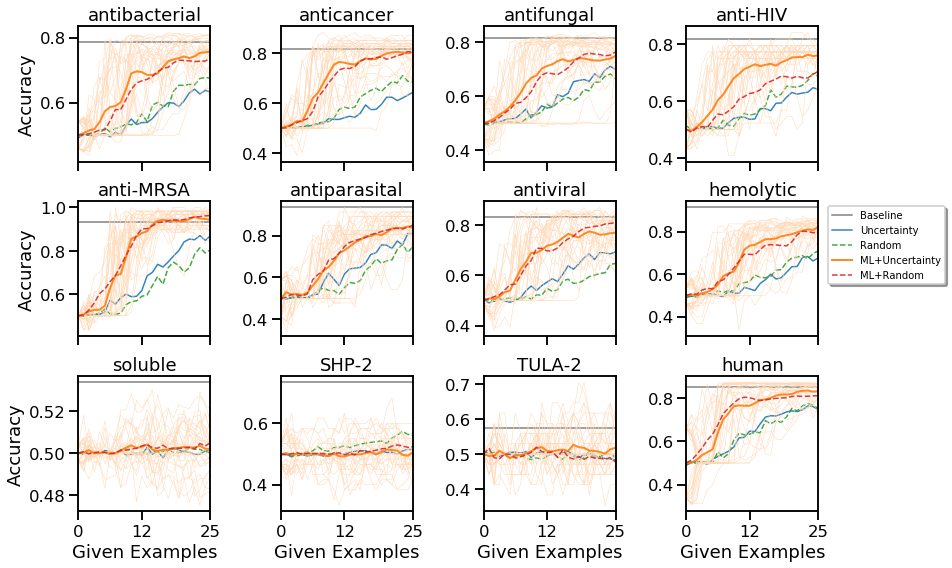

In [30]:
plot_strategy('reptile-models-25', 'models-25', 'umin', ml=True)

Data Standard None Random


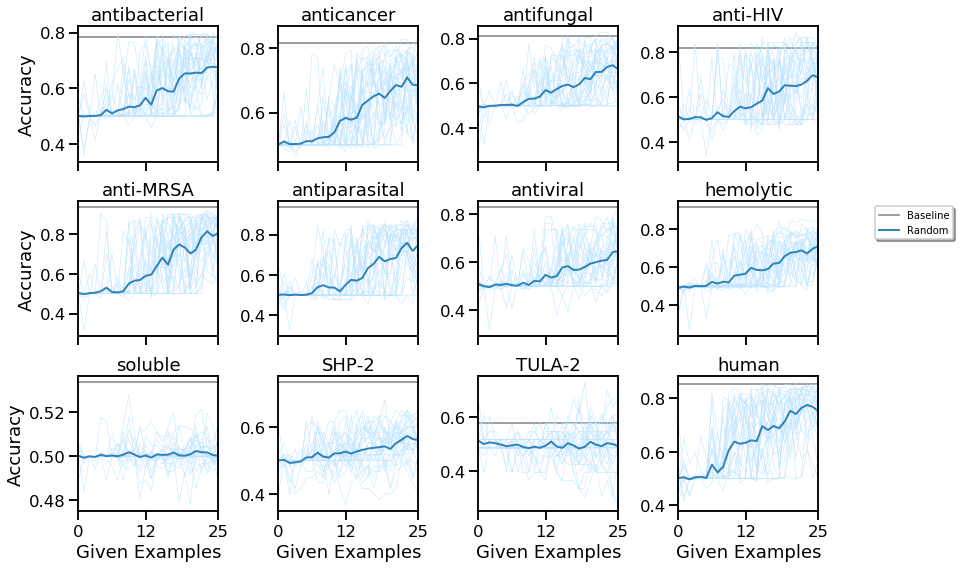

In [31]:
plot_strategy('reptile-models-25', 'models-25', None, ml=False)

Data Standard qbc Random


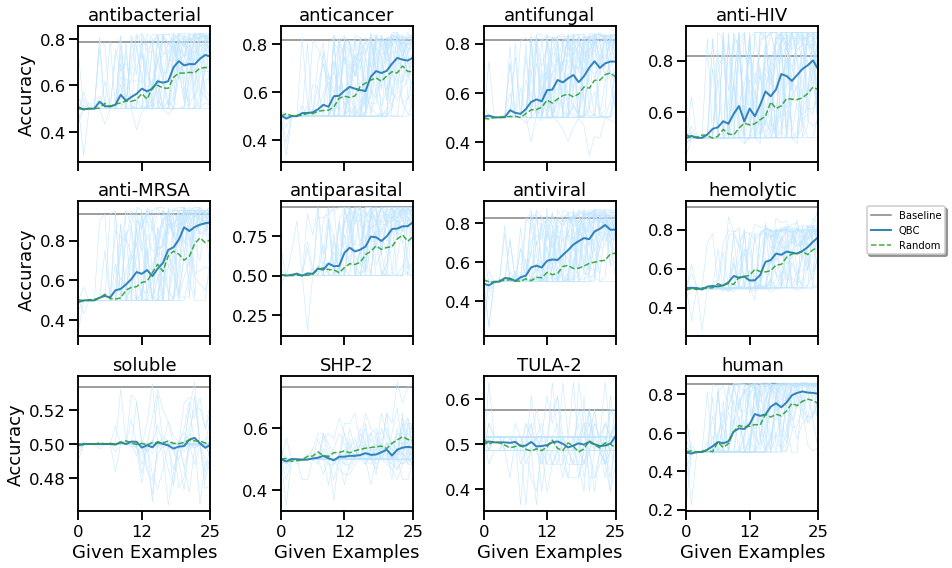

In [32]:
plot_strategy('reptile-models-25', 'models-25', 'qbc', ml=False)

In [728]:
ALPHABET = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']

def decode_motif(array):
    return ''.join([ALPHABET[int(i)] for i in array])

def mode(motifs):
    '''
    computes mode
    '''
    motifs.sort()
    last = motifs[0]
    mode,mode_count,count = last,1,1
    for m in motifs[1:]:
        if m == last:
            count += 1
        elif count >= mode_count:
            mode = last
            mode_count = count
            count = 1
        else:
            count = 1
        last = m
    if count >= mode_count:
        mode = last
        mode_count = count
    return (mode, mode_count / len(motifs))
print(mode(['GGG', 'GGG', 'ERG', 'DFH']))
print(mode(['GGG', 'GGG', 'ERG', 'DFH', 'DFH']))
print(mode(['GGG', 'GGG', 'ERG', 'DFH', 'DFH', 'DFH']))

('GGG', 0.5)
('GGG', 0.4)
('DFH', 0.5)


In [713]:
def get_motifs(location):
    motifs = []
    for i in range(MAX_TRAJS):
        motif_path = '{}/{}_motifs.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(motif_path):
            break
        m = np.genfromtxt(motif_path)
        # sort them so we can get around lack of ordering. 
        motifs.append([decode_motif(mi) for mi in m])
        motifs[-1].sort()
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + motif_path)
    # now we need to histogram them
    motif_modes = []
    for i in range(len(motifs[0])):
        motif_modes.append(mode([m[i] for m in motifs]))
    # sort them
    motif_modes.sort(key = lambda x: x[1])
    return motif_modes
get_motifs('models/all/1')

[('ERCYQI', 1.0),
 ('HMPFQD', 1.0),
 ('IICPTN', 1.0),
 ('QNTKFW', 1.0),
 ('TLVSLV', 1.0)]

In [795]:
def get_count_grads(location):
    count_grads = []
    for i in range(MAX_TRAJS):
        path = '{}/{}_count_grads.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(path):
            break
        m = np.genfromtxt(path)
        count_grads.append(m)
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + path)
    # now we need to get mean
    cg_mean = np.mean(count_grads, axis=0)
    #print('TODO: I do not know if this is valid....')
    #cg_mean -= np.mean(cg_mean)
    cg_mean = np.abs(cg_mean)
    return cg_mean
get_count_grads('models/all/0')

array([0.2371705 , 0.27288078, 0.08585913, 0.25336392, 0.08395854,
       0.09191131, 0.15176791, 0.02440531, 0.31859886, 0.47360375,
       0.14891433, 0.1338726 , 0.03544035, 0.02130003, 0.3232203 ,
       0.05402537, 0.05668401, 0.11040263, 0.42298005, 0.20071956,
       0.45170282])

In [798]:
def plot_explain(location, name, motif_width=6, ax=None, labelx = True, labely_left = True, labely_right = True):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.grid(linewidth=1, linestyle='--', zorder=1)
    
    cg = get_count_grads(location)
    # make y-axis symmetric
    ymax = max(abs(min(cg)), abs(max(cg)))
    ax.set_ylim(0, ymax)
    x = list(range(len(cg)))
    ax.bar(x, height=cg, zorder=99)
    ax.set_yticks([])
    if labelx:
        #ax.set_xticks(x + [x[-1] + 1 + motif_width // 2])
        ax.set_xticks(x)
        ax.set_xticklabels(['Z'] + ALPHABET + ['Motifs'], fontdict={'size': 18, 'family': 'monospace'})
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(['Z'] + ALPHABET, fontdict={'size': 12, 'family': 'monospace'})
    if labely_left:
        ax.set_ylabel('Class Effect', fontsize=24)
    ax.set_xlim(-1,x[-1] + 1 + motif_width)
    ax.axvline(x[-1] + 1, color='black')
    ax2 = ax.twinx()
    motifs = get_motifs(location)
    yticks = []
    for i,m in enumerate(motifs):
        y = i + 0.5
        yticks.append(y)
        ax2.text(x[-1] + 0.5 + motif_width, y, verticalalignment='center', 
                s=motifs[i][0], fontdict={'size': 16, 'family': 'monospace'},
               horizontalalignment='right')
    ax2.set_ylim(0,len(motifs))
    ax2.set_yticks(yticks)
    ax2.set_yticklabels(['{:.2f}'.format(m[1]) for m in motifs])
    if labely_right:
        ax2.yaxis.set_label_position('right')
        ax2.set_ylabel('Motif Frequency', rotation=-90, labelpad=25, fontsize=24)
    ax.set_title(name, fontsize=24)

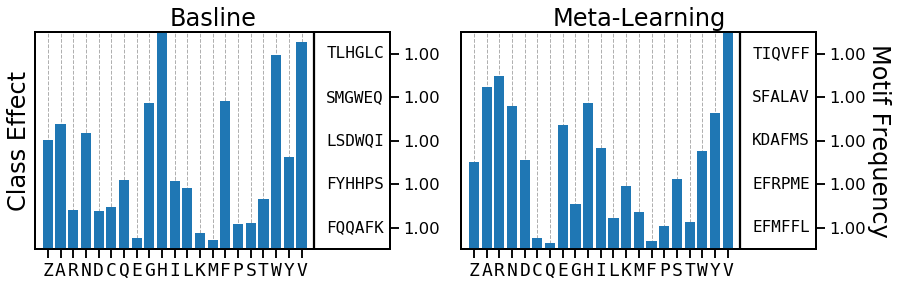

In [830]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
plot_explain('models/all/0', 'Basline', ax=axs[0], labely_left=True, labelx=True, labely_right=False)
plot_explain('reptile-models-25/umin/0zero', 'Meta-Learning', ax=axs[1], labely_right=True, labely_left=False, labelx=True)
plt.savefig('interp-compare.png', dpi=300)
plt.show()

In [716]:
def plot_interpret(location_root, strategy, suffix=''):
    fig, axs= plt.subplots(nrows=3, ncols=4, figsize=(28,16), sharex=False, sharey=False)
    for i in range(3):
        for j in range(4):
            k = i * 4 + j
            plot_explain(os.path.join(location_root, strategy, '{}{}'.format(k, suffix)), 
                         names[k], ax=axs[i,j], labelx = i == 2, labely_right = j == 3,
                         labely_left = j == 0)
    plt.savefig('interpret-{}.png'.format(strategy), dpi=300)
    #plt.show()

TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....


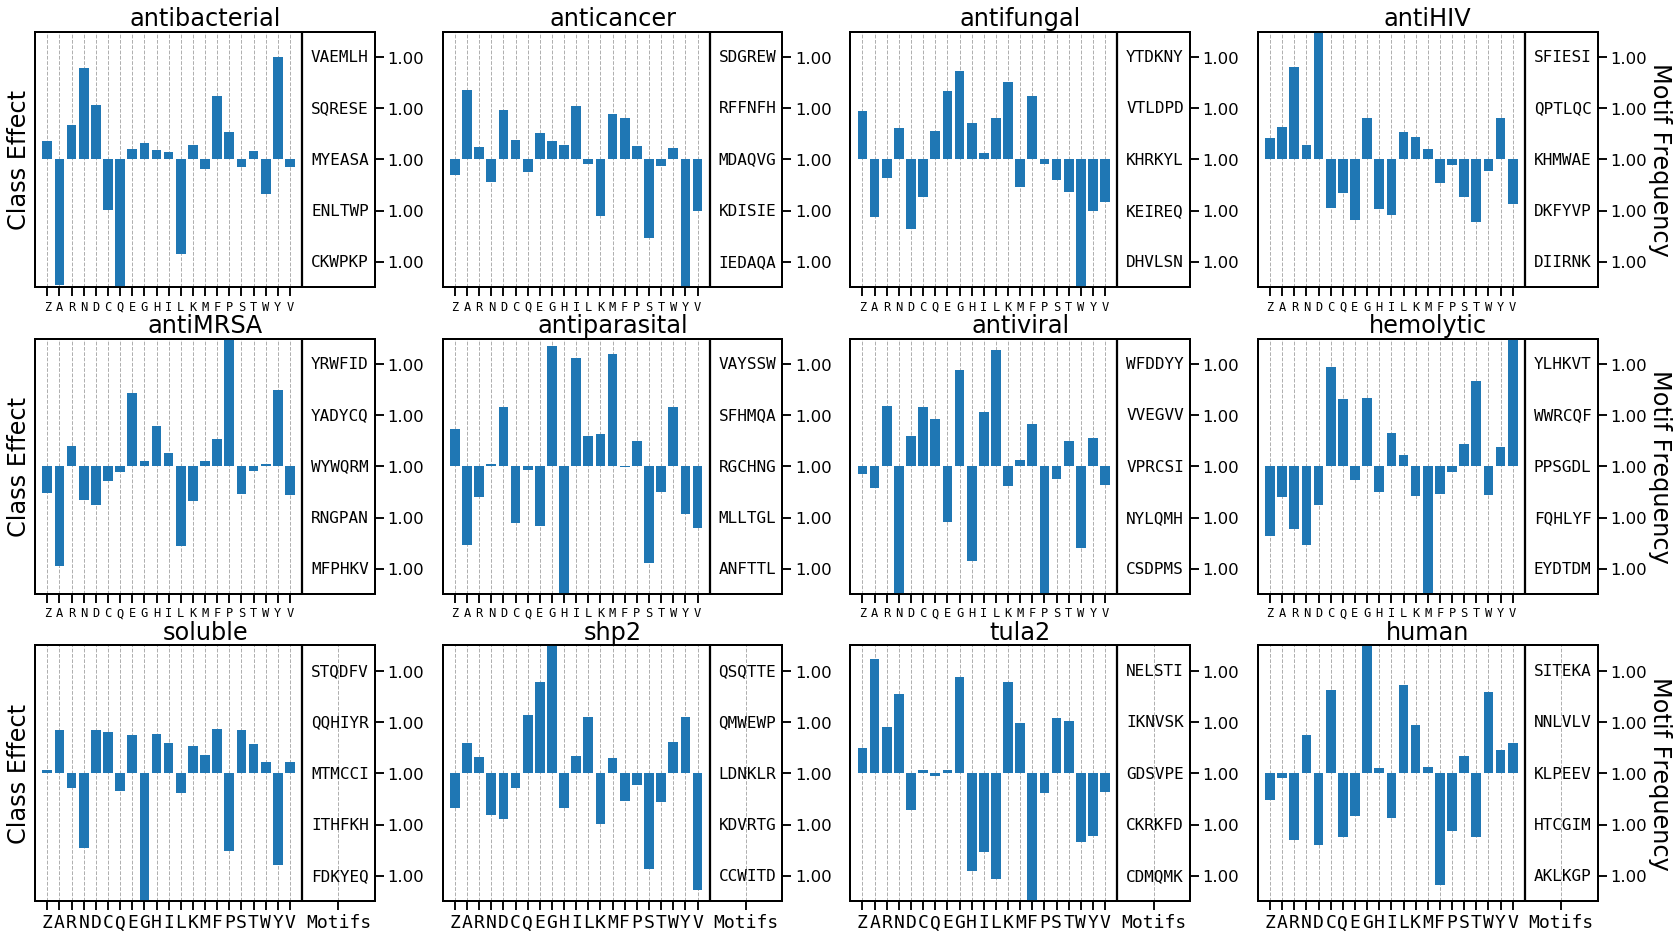

In [717]:
plot_interpret('reptile-models/', 'random', 'zero')

TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....
TODO: I do not know if this is valid....


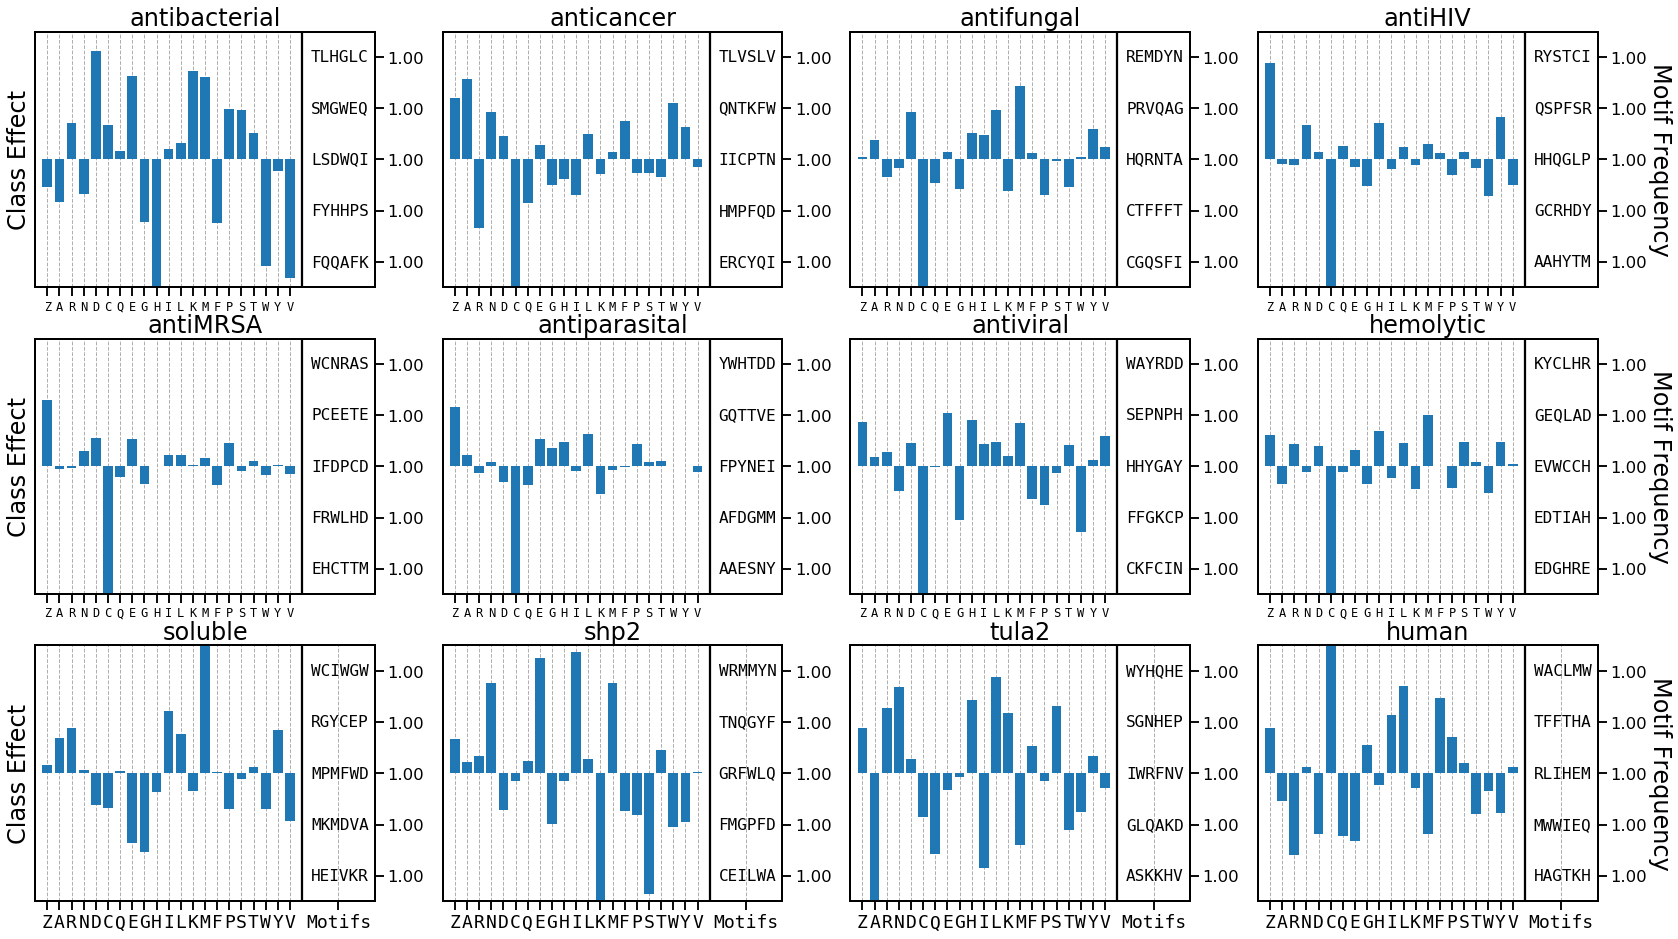

In [718]:
plot_interpret('models', 'all')

TODO: I do not know if this is valid....


<Figure size 180x144 with 0 Axes>

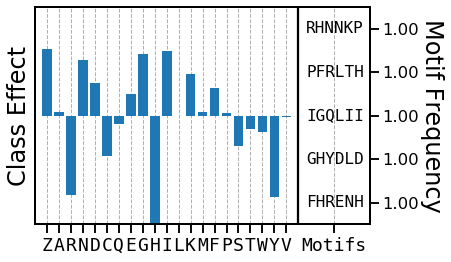

In [621]:
plt.figure(figsize=(2.5,2))
plot_explain(os.path.join('reptile-models', 'random', '{}{}'.format(0, 'zero')), 
                         '', labelx = True, labely_right=True,
                         labely_left = True)
plt.show()

(25, 51)
(25, 51)


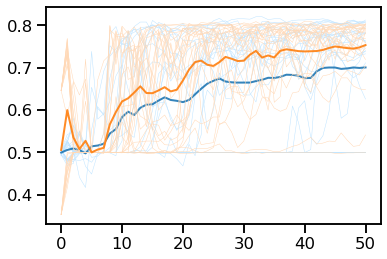

In [562]:
plt.figure()
ax = plt.gca()
plot_condition(ax, 'foo', 'C0', '-', 'test-reptile-models/random/0', trace=True)
plot_condition(ax, 'foo', 'C1', '-', 'test-reptile-models/umin/0/', trace=True)
plt.show()

(25, 51)
(25, 51)
(30, 51)


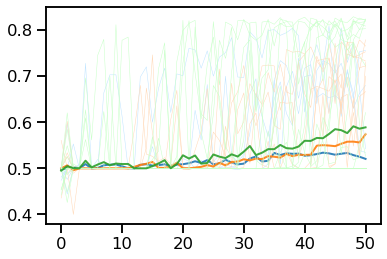

In [565]:
plt.figure()
ax = plt.gca()
plot_condition(ax, 'foo', 'C0', '-', 'models-/random/0', trace=True)
plot_condition(ax, 'foo', 'C1', '-', 'test-models/umin/0/', trace=True)
plot_condition(ax, 'foo', 'C2', '-', 'models/qbc/0/', trace=True)
#plt.xlim(0,25)
plt.show()

(30, 51)


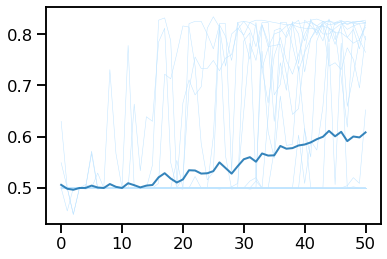

In [564]:
plt.figure()
ax = plt.gca()
plot_condition(ax, 'foo', 'C0', '-', 'models/qbc/2', trace=True)
plt.show()

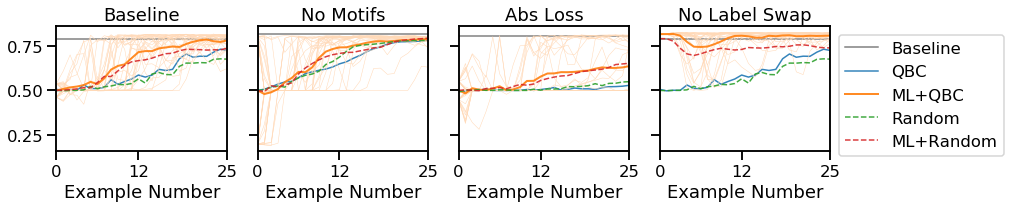

In [858]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(14, 3), sharey=True)
plot_dataset(axs[0], 'reptile-models-25', 'models-25', 'qbc', 0, False, ml=True, title='Baseline')
plot_dataset(axs[1], 'reptile-models-abl-A', 'models-abl-A', 'qbc', 0, False, ml=True, title='No Motifs', baseline_loc='models-25')
#axs[1].yaxis.set_labels([])
plot_dataset(axs[2], 'reptile-models-abl-B', 'models-abl-B', 'qbc', 0, False, ml=True, title='Abs Loss', baseline_loc='models-25')
#axs[2].yaxis.set_tricks([])
plot_dataset(axs[3], 'reptile-models-abl-C', 'models-25', 'qbc', 0, False, ml=True, title='No Label Swap', baseline_loc='models-25')
plt.legend(bbox_to_anchor=(1.0, 1.0))
for ax in axs:
    ax.set_xlabel('Example Number')
plt.tight_layout()
plt.savefig('ablation.png', dpi=300)
plt.show()
